# Batch normalization in Deep neural networks

# Introduction
Though neural networks became the state of the art in many modeling problems,it is sometimes difficult to get it work for a desired task. One may face many different problems during implementation for example the learning is too slow (loss not reducing after many epochs), 'nan' loss shows up suddenly while training, loss suddenly increases to a very large number, to list out a few. We may be dealing with large amount of data and complex model architecture with many hyperparameters, hence it may be difficult sometimes to debug. There are many 'tricks' or 'hacks' one can try while training a neural network to overcome many issues, and batch normalization is one such tool that can be useful in making the training really fast.

This notebook tries to demonstrate the effect of batch normalization in a simple regression problem. Please note that this is a very small dataset and you may not necessarily require batch normalization. This is just to demonstrate how to implement batch norm and really understand its application, when the dataset is very large and the loss is not reducing for many epochs or you observe vanishing/exploding gradients.

# Standardization
Standardization is a widely used data preprocessing technique to transform data to a distribution of zero mean and unit standard deviation. This transforms the input data in same range, making algorithms like gradient descent to converge faster. This is one of the widely used data normalization techniques, and a variation of the same is used in batch normalization technique.

For a given input feature  x(i)
 , its normalized version is:

z(i)norm=x(i)−μiσi
 

where  μi
  is the mean of the feature and  σi
  is the standard deviation of the feature. During implementation, a small  ϵ
  is added to standard deviation to avoid division by zero error.

# Batch normalization
in the case of deep neural network, standardizing inputs alone may not improve its training. Each hidden layer's input is the output of previous layer and inputs not in the same range can have an impact at any given layer in a Neural network. Batch normalization is the technique of standardizing (or normalizing) the input vectors at any given hidden layer, not necessarily be the input layer of a nerual network. For inputs, mean vector and standard deviation vectors can be obtained directly from the data. Since the inputs at intermediate layers are calculated during the forward pass, the mean vector and standard deviation vectors are also calculated within the foreward pass. For larger datasets, instead of using entire train data for one iteration of weight updates, the practical approach is to use mini-batches, and hence, the normalization is also applied 'batch-wise', hence the name "batch normalization"

Internal covariate shift

The change in the distribution of the input to a particular layer across batches is known as internal covariate shift, and batch normalization to an extent can be used to tackle this issue

# Batch normalization in action
While implementing batch normalization, there are some tricks widely followed by Deep learning practitioners. Some of them are ((Please note that when it is referred as inputs, it also considers the intermediate inputs):

Batch normalization applied to outputs of a layer before activation tends to give better results

There is no need for intermediate inputs to follow mean zero and unit variance. This may have counter-effects for activation functions like sigmoid layer. So two trainiable parameters per input unit, " β
 " and " γ
 " is introduced as parameters that define the nature of input distribution.For a given input unit  x(i)
 , its transformed version is:
z′(i)=γiz(i)norm+βi
 
where  zinorm
  is  xi
  transformed to zero mean and unit variance

At inference time, we may not have necessarily a to compute mean and variance. To overcome this, while training, model maintains a moving average of mean and standard deviation which is accumulated across batches and used at the inference time.

# roblem Statement
Ref - https://www.kaggle.com/datasets/vikrishnan/boston-house-prices

Consider the Boston housing data. Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1): CRIM: per capita crime rate by town

1) CRIM - per capita crime rate by town
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS: proportion of non-retail business acres per town
4) CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5) NOX: nitric oxides concentration (parts per 10 million)
6) RM: average number of rooms per dwelling
7) AGE: proportion of owner-occupied units built prior to 1940
8) DIS: weighted distances to ﬁve Boston employment centers
9) RAD: index of accessibility to radial highways
10) TAX: full-value property-tax rate per 10,000 doller
11) PTRATIO: pupil-teacher ratio by town
12) B: (1000(Bk−0.63)2) where Bk is the proportion of blacks by
13) LSTAT: % lower status of the population
14) MEDV: Median value of owner-occupied homes in 1000 doller

Our aim is to create a machine learning model to predict MEDV from the given data.

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras import activations
# from tensorflow_addons.metrics import RSquare

# Read Data
Ref - https://www.kaggle.com/code/anurag629/boston-house-prices-regression-model

In [17]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(r'C:\Users\Shiva\Downloads\FSDS---srinu\kaggle,linkedin\Boston House Prices.csv',
header = None, delimiter=r'\s+', names=columns)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Pearson correlation coefficient

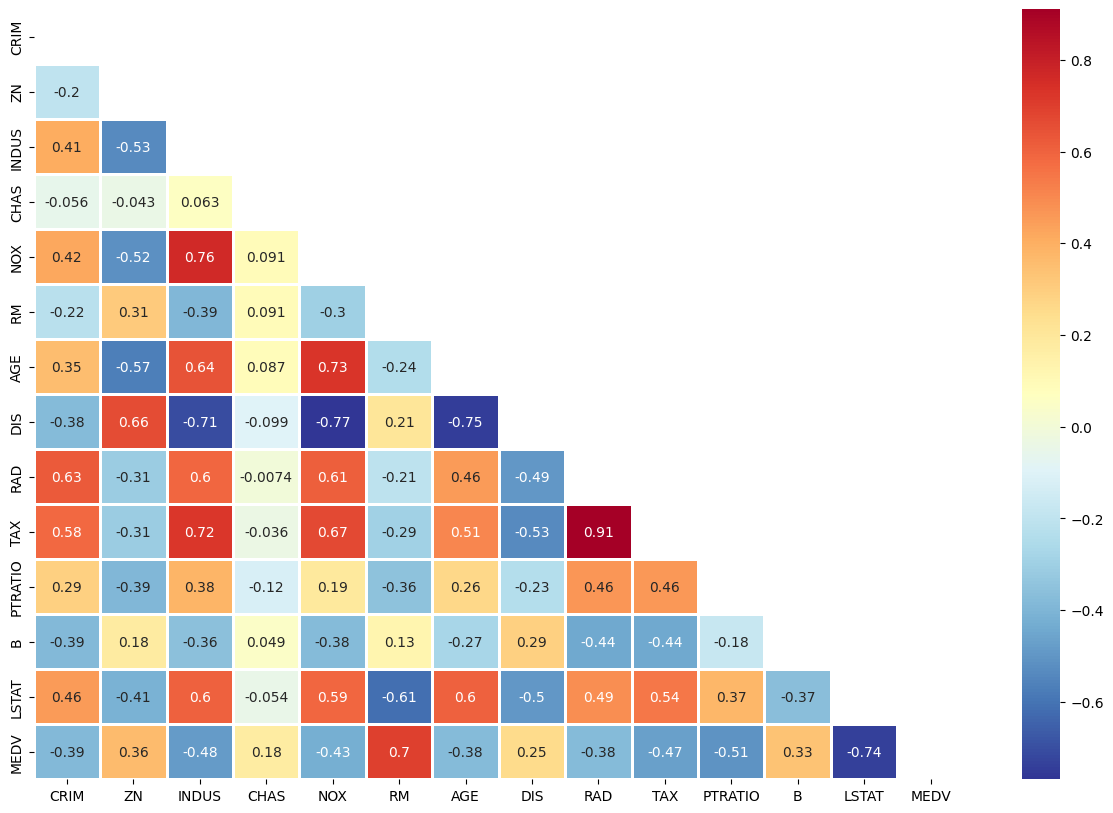

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(data=df.corr(), mask=np.triu(df.corr()), annot=True,
cmap='RdYlBu_r',
           linewidth=1, linecolor='white')
plt.show()

# Unique values (understand the variations in features)

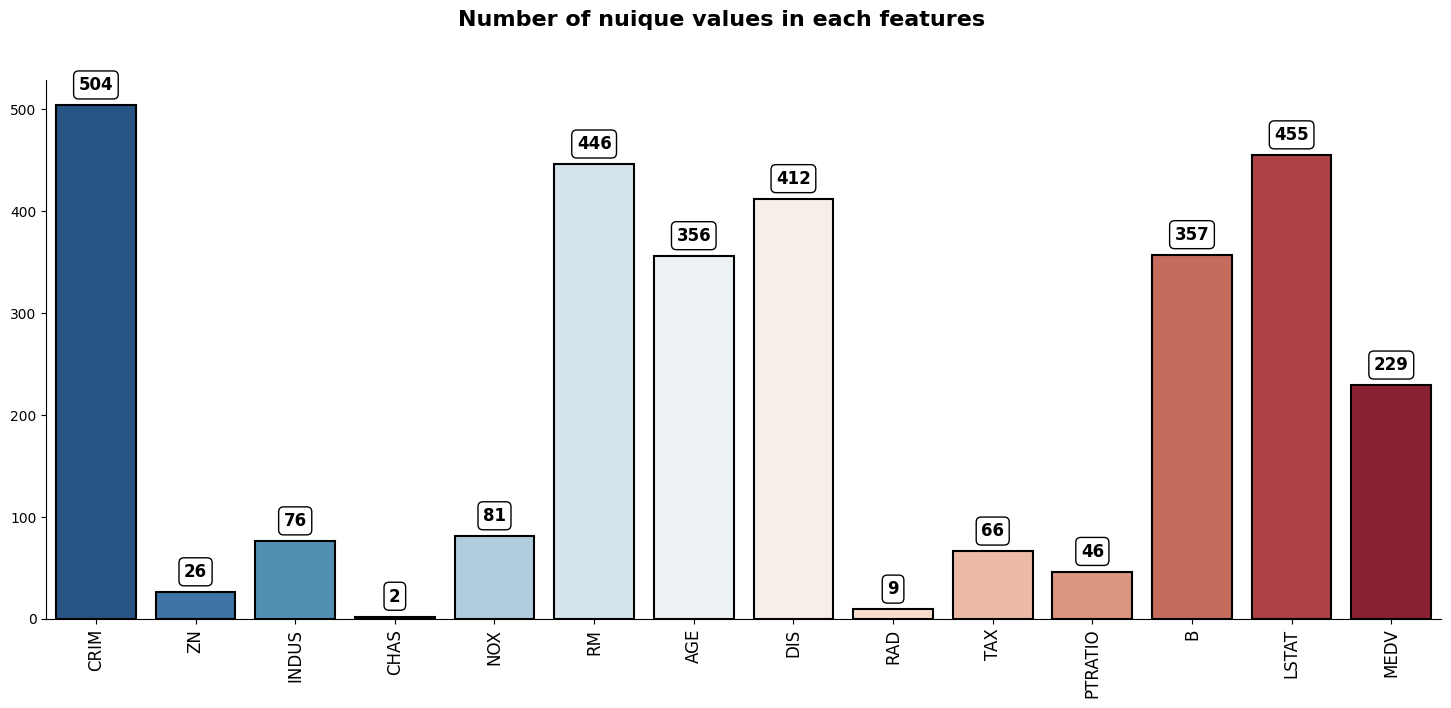

In [19]:
plt.figure(figsize=(18,7))
ax = sns.barplot(x=df.columns, y=df.nunique().values,
            palette='RdBu_r', linewidth=1.5, edgecolor='black')
plt.xticks(rotation=90, fontsize=12)
for p in ax.patches:
    value = f'{p.get_height():,.0f}'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 20
    ax.text(x, y, value, fontsize=12, ha='center', va='center', 
weight='bold',
           bbox=dict(facecolor='white', boxstyle='round', linewidth=1,
edgecolor='k'))
plt.suptitle(t = 'Number of nuique values in each features', fontsize= 16,
weight= 'bold')
sns.despine()
plt.show()
    

# Input data Normalization
We will standardize the input data before modeling. This can be done also using the normalization layer during the foreward pass of neural network, but since it is known data, we can calculate the total mean and standard deviation, so no need for a normalization layer for inputs.

We will use sklearn standardscaler to scale the data

Ref : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [21]:
X = df.drop(columns=['MEDV']).values
y = df.MEDV.values
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1,1))

# Train-test split
We split a random 80% of the data as train set for training the model and test the model in the remaining 20% of the data

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

Now, we will start the modeling part. We will have models:

Model 1 : Without any batch normalisation for the hidden layers

Model 2 : With batch normalisation applied for the hidden layer inputs

Train-test data and rest of all the hyperparameters are same for both the models.

# Model Definition
We will define a deep neural network with 3 hidden layers, with 64,32 and 16 nodes respectively. We will use a batch size of 64 and dropout probability 0.25. We will train the model for 250 epochs, with SGD of learning rate 0.01 as optimizer, minimising "mse" loss. ReLU activation is used as activation function.

# Model 1 (without batch normalization)

In [23]:
n_features = X.shape[1]
dropout_proba = 0
batch_size = 64
opt = SGD(learning_rate=0.01)
epochs = 250

In [28]:
import tensorflow as tf

def DNN_model(layers, n_features, dropout, act='relu'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(layers[0], input_dim=n_features, activation=act))
    for layer in layers[1:]:
        model.add(tf.keras.layers.Dense(layer, activation=act))
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1))
    return model

model = DNN_model([64, 32, 16], n_features, dropout_proba, act='relu')
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
print(model.summary())
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                896       
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,521
Trainable params: 3,521
Non-trainabl

In [31]:
y_pred = model.predict(X_test)
print('Model score:',r2_score(y_test,y_pred))

4/4 [==============================] - 0s 997us/step
Model score: -0.006422803690073087


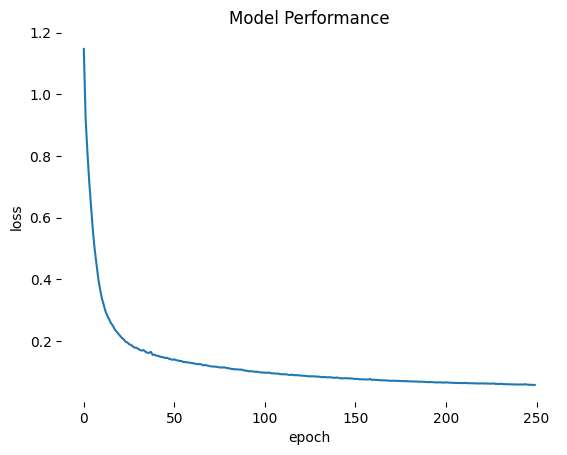

In [33]:
#history.history['accuracy']
plt.plot(history.history['loss'])
plt.title('Model Performance')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train','val'],loc='upper right')
plt.box(False)
plt.show()

# Model 2 (with batch normalization)

In [34]:
def DNN_model_with_BN(layers_shape, input_dim, dropout_proba, act='relu'):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation='linear')(inputs)
    hidden = BatchNormalization(axis=1)(hidden)
    hidden = Activation(activations.relu)(hidden)
    for i in range(len(layers_shape)-1):
        hidden = Dense(layers_shape[i+1], activation='linear')(hidden)
        hidden = BatchNormalization(axis=1)(hidden)
    outputs = Dense(units=1, kernel_initializer = 'uniform', activation = 'linear')(hidden)
    model = Model(inputs, outputs)
    return model


In [36]:
opt2 = SGD(learning_rate=0.01)
model2 = DNN_model_with_BN([64,32,16],n_features, dropout_proba,act='relu')
model2.compile(optimizer = opt2, loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()])
print(model2.summary)
history2 = model2.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=0)

<bound method Model.summary of <keras.engine.functional.Functional object at 0x000001B4CF5E62F0>>


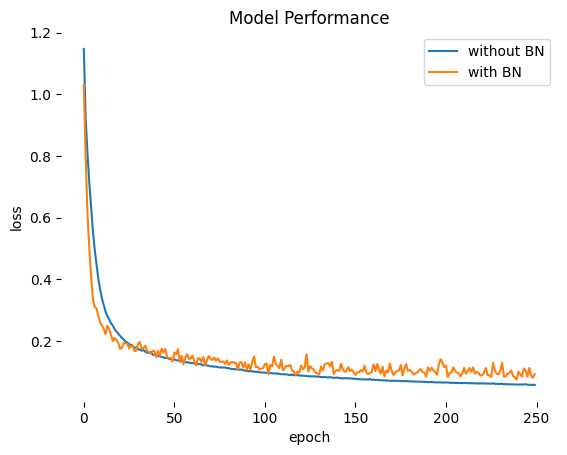

In [37]:
#history.history['accuracy']
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.title('Model Performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['without BN', 'with BN'], loc='upper right')
plt.box(False)
plt.show()

In [38]:
y_pred = model2.predict(X_test)
print('Model score:', r2_score(y_test,y_pred))

4/4 [==============================] - 0s 1ms/step
Model score: 0.8849614914041671


# Observations
We can clearly see the loss is reducing faster for the model with batch normalization
Batch normalization also have a small regularization effect, this may be a reason for the improvement of performance of model 2. Though it have a slight regularization effect, for regularization, methods like dropout, L1, L2 norm techniques are always recommended than using batch normalization.
There are also other tricks like layer normalization, gradient clipping etc that are effective in making the training fast, tackle vanishing gradient/exploding gradient problems etc.